# Project 3: Poisonous mushrooms

In this project, you'll investigate properties of mushrooms. This classic dataset contains over 8000 observations, where each mushroom is described by a variety of features like color, odor, etc., and the target variable is an indicator for whether the mushroom is poisonous. Since all the observations are categorical, I've binarized the feature space. Look at the feature_names below to see all 126 binary names.

You'll start by running PCA to reduce the dimensionality from 126 down to 2 so that you can easily visualize the data. In general, PCA is very useful for visualization (though sklearn.manifold.tsne is known to produce better visualizations). Recall that PCA is a linear transformation. The 1st projected dimension is the linear combination of all 126 original features that captures as much of the variance in the data as possible. The 2nd projected dimension is the linear combination of all 126 original features that captures as much of the remaining variance as possible. The idea of dense low dimensional representations is crucial to machine learning!

Once you've projected the data to 2 dimensions, you'll experiment with clustering using KMeans and density estimation with Gaussian Mixture Models. Finally, you'll train a classifier by fitting a GMM for the positive class and a GMM for the negative class, and perform inference by comparing the probabilities output by each model.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GMM
from matplotlib.colors import LogNorm

In [2]:
## STUDENT imports
import sys
import time
import pandas as pd
from itertools import product

from matplotlib.ticker import FuncFormatter
import matplotlib.gridspec as gridspec

from IPython.core.display import clear_output

# Set plot style
plt.style.use('ggplot')

Load feature names.

In [3]:
feature_names = []
with open('data/mushroom.map') as fmap:
    for line in fmap:
        [index, name, junk] = line.split()
        feature_names.append(name)

print 'Loaded feature names:', len(feature_names)

Loaded feature names: 126


Load data. The data is sparse in the input file, but there aren't too many features, so we'll use a dense representation, which is supported by all sklearn objects.

In [4]:
X, Y = [], []

with open('data/mushroom.data') as fdata:
    for line in fdata:
        items = line.split()
        Y.append(int(items.pop(0)))
        x = np.zeros(len(feature_names))
        for item in items:
            feature = int(item.split(':')[0])
            x[feature] = 1
        X.append(x)

# Convert these lists to numpy arrays.
X = np.array(X)
Y = np.array(Y)

# Split into train and test data.
train_data, train_labels = X[:7000], Y[:7000]
test_data, test_labels = X[7000:], Y[7000:]

# Check that the shapes look right.
print train_data.shape, test_data.shape

(7000, 126) (1124, 126)


**STUDENT:**  
Create color palettes.  

In [5]:
MY_COLORS16 = [(0.86, 0.37119999999999997, 0.33999999999999997),
     (0.86, 0.56619999999999993, 0.33999999999999997),
     (0.86, 0.7612000000000001, 0.33999999999999997),
     (0.76380000000000003, 0.86, 0.33999999999999997),
     (0.56880000000000008, 0.86, 0.33999999999999997),
     (0.37380000000000008, 0.86, 0.33999999999999997),
     (0.33999999999999997, 0.86, 0.50120000000000009),
     (0.33999999999999997, 0.86, 0.69620000000000015),
     (0.33999999999999997, 0.82879999999999987, 0.86),
     (0.33999999999999997, 0.63379999999999981, 0.86),
     (0.33999999999999997, 0.43879999999999986, 0.86),
     (0.43619999999999975, 0.33999999999999997, 0.86),
     (0.63119999999999976, 0.33999999999999997, 0.86),
     (0.82619999999999982, 0.33999999999999997, 0.86),
     (0.86, 0.33999999999999997, 0.69879999999999964),
     (0.86, 0.33999999999999997, 0.50379999999999958)]

**NOTE:**  
These palettes were created using seaborn palette generator:
```python
import seaborn as sns
MY_COLORS16 = sns.color_palette("hls", 16)
sns.palplot(MY_COLORS16)
MY_COLORS16
```

**STUDENT:**  
Create a `UNIQUE_FEATURES` set with the non-binarized feature names for exploration.

In [6]:
UNIQUE_FEATURES = set()

for f in feature_names:
    UNIQUE_FEATURES.add(f.split('=')[0])

print '  Unique features'
print '  ==============='
for f in UNIQUE_FEATURES:
    print ' +', f

  Unique features
 + habitat
 + cap-shape
 + cap-color
 + stalk-color-above-ring
 + stalk-shape
 + gill-attachment
 + bruises?
 + ring-number
 + stalk-surface-below-ring
 + gill-size
 + stalk-color-below-ring
 + veil-color
 + odor
 + gill-spacing
 + spore-print-color
 + gill-color
 + population
 + stalk-root
 + ring-type
 + stalk-surface-above-ring
 + veil-type
 + cap-surface


(1) Run Principal Components Analysis on the data. Show what fraction of the total variance in the training data is explained by the first k principal components, for k in [1, 50].

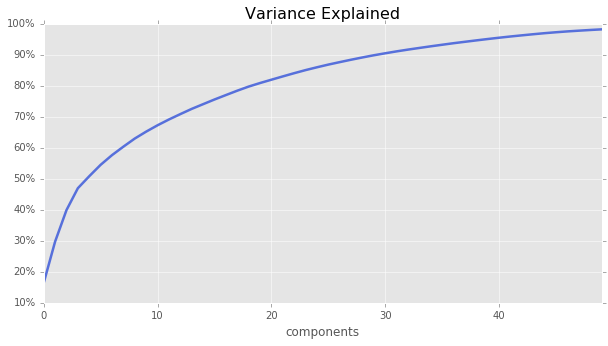

,last_component,var_explained
components,,
0,0.164043,0.164043
1,0.133235,0.297278
2,0.101735,0.399013
3,0.070634,0.469646
4,0.038666,0.508313
5,0.036808,0.545121
6,0.031282,0.576403
7,0.027337,0.603741
8,0.026165,0.629905


In [7]:
def P1(k_max=50):

### STUDENT START ###

    # Create PCA with max number of k-components
    pca = PCA(n_components=k_max)
    pca.fit(train_data)

    # Add to dataframe and calculate cumulative gain
    var_df = pd.DataFrame({'components': range(k_max),
                           'last_component': pca.explained_variance_ratio_})
    var_df['var_explained'] = var_df[['last_component']].cumsum()
    
    # Plot cumulative explained variance
    var_df.set_index('components', inplace=True)
    fig = var_df[['var_explained']].plot(figsize=(10,5), legend=False, lw=2.5, color=MY_COLORS16[10])
    plt.title('Variance Explained', fontsize=16)
    fig.yaxis.set_major_formatter(FuncFormatter(lambda y,pos: ('{0:.0%}'.format(y))))
    plt.show()

    # Report variance explained
    return var_df
    
### STUDENT END ###

P1()

(2) PCA can be very useful for visualizing data. Project the training data down to 2 dimensions and plot it. Show the positive (poisonous) cases in blue and the negative (non-poisonous) in red. Here's a reference for plotting: http://matplotlib.org/users/pyplot_tutorial.html

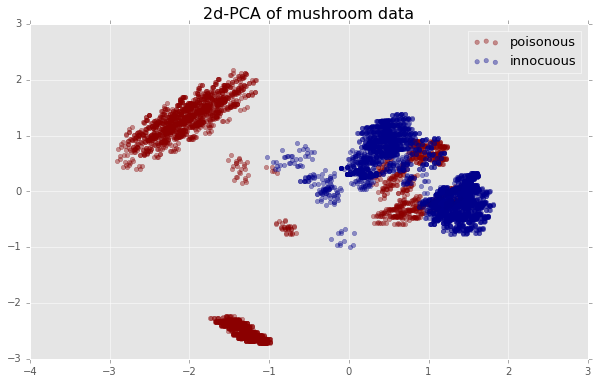

In [8]:
def P2():

### STUDENT START ###

    # Fit and transform data to 2d
    pca = PCA(n_components=2)
    train_2d = pca.fit_transform(train_data)

    # Plot
    fig, ax = plt.subplots(1, figsize=(10,6))

    ax.scatter(train_2d[train_labels==1, 0], train_2d[train_labels==1, 1],
               label='poisonous', color='darkred', alpha=.4)
    ax.scatter(train_2d[train_labels==0, 0], train_2d[train_labels==0, 1],
               label='innocuous', color='darkblue', alpha=.4)
    ax.legend(loc='best', fontsize=13)
    ax.set_title('2d-PCA of mushroom data', fontsize=16)

    plt.show()
    
    return train_2d, pca

### STUDENT END ###

train_data_2d, pca_2d = P2()

(3) Run KMeans with [1,16] clusters over the 2d projected data. Mark each centroid cluster and plot a circle that goes through the most distant point assigned to each cluster.

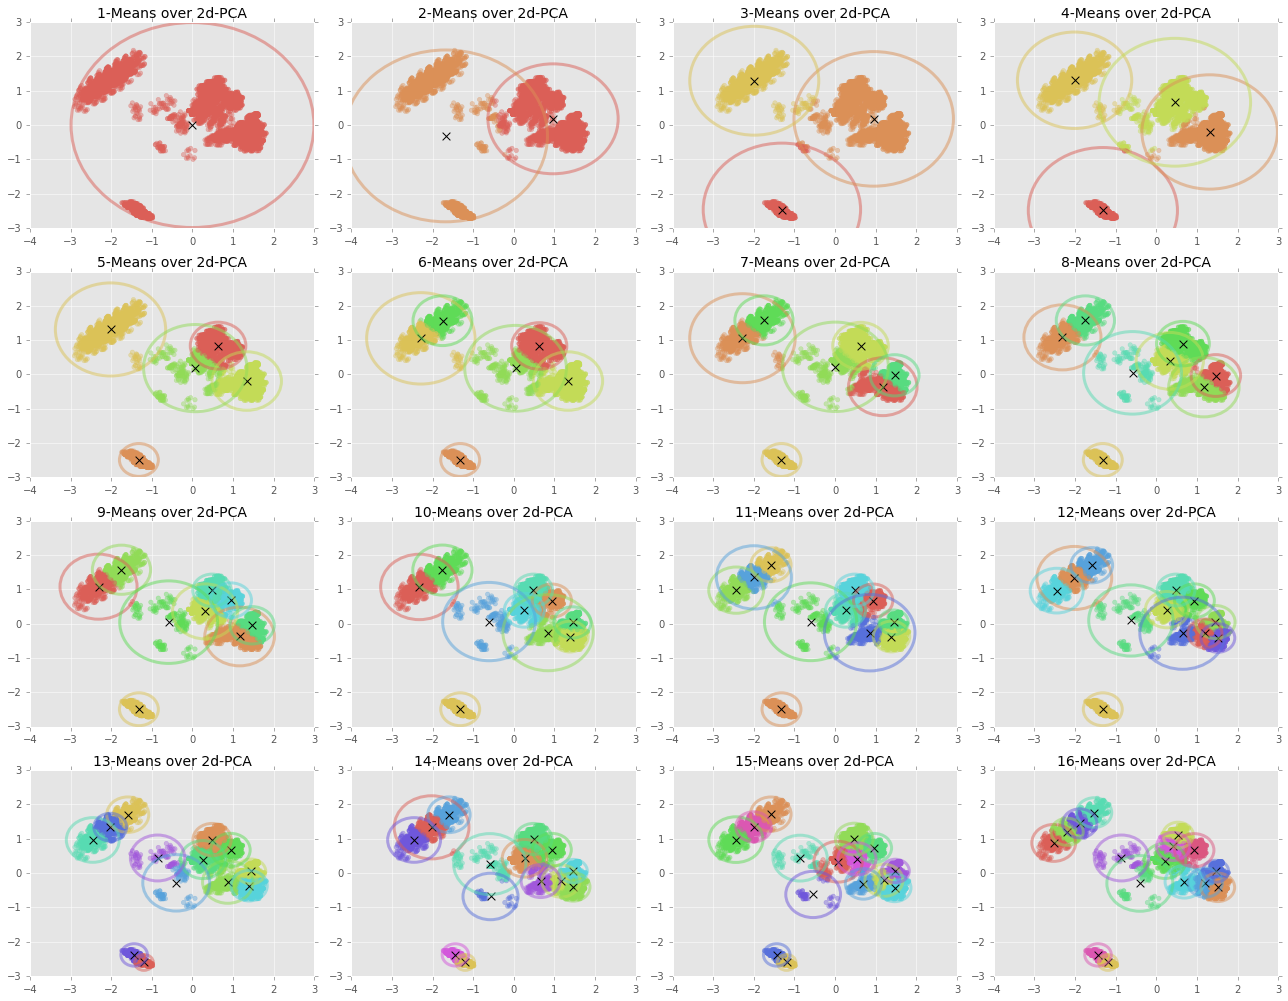

In [9]:
def P3(data_2d):

### STUDENT START ###

    # Initialize plot figure
    fig = plt.figure(figsize=(18, 14)) 
    gs = gridspec.GridSpec(4, 4)

    for i, _g in enumerate(gs):
        k = i + 1 # number of clusters
        ax = plt.subplot(_g)

        _km = KMeans (n_clusters=k, init='k-means++')
        _clstrs = _km.fit(data_2d)

        # Set color labels
        color_labels = [ MY_COLORS16[x] for x in _clstrs.labels_ ]

        # Get distance to farthest point in the cluster
        _distances = _km.transform(data_2d)
        _dist_df = pd.DataFrame({'distance': _distances.min(axis=1), 'label': _clstrs.labels_})
        _radii = _dist_df.groupby('label').max()

        # Plot: circumference -> scatter -> centroids
        for j in xrange(_radii.shape[0]):
            _c = plt.Circle(_clstrs.cluster_centers_[j], radius=_radii.loc[j], fill=False,
                            color=MY_COLORS16[j], lw=3, alpha=.5)
            ax.add_artist(_c)
        ax.scatter(data_2d[:, 0], data_2d[:, 1], color=color_labels, alpha=.4)
        ax.scatter(_clstrs.cluster_centers_[:,0], _clstrs.cluster_centers_[:,1], marker='x', c='black', lw=1, s=60)
        ax.set_title('{}-Means over 2d-PCA'.format(k), fontsize=14)

    plt.tight_layout()
    plt.show()


### STUDENT END ###

P3(train_data_2d)

(4) Fit a Gaussian Mixture Model for the positive examples in your 2d projected data. Plot the estimated density contours as shown here: http://scikit-learn.org/stable/auto_examples/mixture/plot_gmm_pdf.html#example-mixture-plot-gmm-pdf-py. Vary the number of mixture components from 1-4 and the covariance matrix type ('spherical', 'diag', 'tied', 'full').

/Users/will/miniconda3/envs/py2/lib/python2.7/site-packages/matplotlib/contour.py:1538: UserWarning: Log scale: values of z <= 0 have been masked
  warnings.warn('Log scale: values of z <= 0 have been masked')


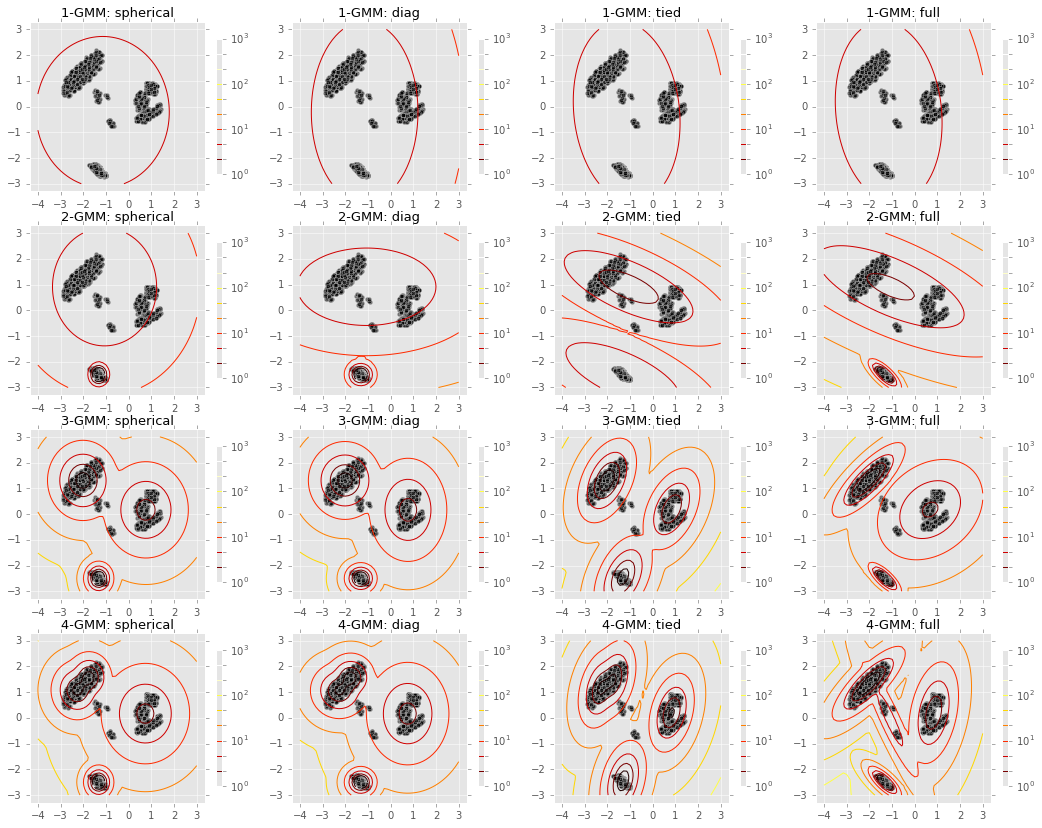

In [10]:
def P4(data_2d, components=(1, 2, 3, 4), covariance=('spherical', 'diag', 'tied', 'full')):

### STUDENT START ###

    combinations = product(components, covariance)
    positive_data = data_2d[train_labels==1,:]

    # Initialize plot figure
    fig = plt.figure(figsize=(18, 14)) 
    gs = gridspec.GridSpec(len(components), len(covariance))

    for i, _g in enumerate(gs):
        _comp, _cov = combinations.next()
        ax = plt.subplot(_g)

        # Fit GMM model
        gm_mod = GMM(n_components = _comp, covariance_type=_cov)
        gm_mod.fit(positive_data)

        # predicted scores as contour plot
        x = np.linspace(-4.0, 3.0)
        y = np.linspace(-3.0, 3.0)
        X, Y = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y.ravel()]).T
        Z = -gm_mod.score_samples(XX)[0]
        Z = Z.reshape(X.shape)

        CS = ax.contour(X, Y, Z, norm=LogNorm(vmin=.8, vmax=300.0), levels=np.logspace(0, 3, 10), cmap=plt.cm.hot)
        CB = plt.colorbar(CS, shrink=0.8, extend='both')
        ax.scatter(positive_data[:, 0], positive_data[:, 1], c='black', alpha=.5)
        ax.set_title('{}-GMM: {}'.format(_comp, _cov), fontsize=13)

    plt.show()

### STUDENT END ###

P4(train_data_2d)

(5) Fit two 4-component full covariance GMMs, one for the positive examples and one for the negative examples in your 2d projected data. Predict the test examples by choosing the label for which the model gives a larger probability (use GMM.score). What is the accuracy?

In [11]:
def P5():

### STUDENT START ###

    positive_data = train_data_2d[train_labels==1,:]
    negative_data = train_data_2d[train_labels==0,:]

    # Fit 4-component GMM models for Poisonous and Innocuos
    gm_pos = GMM(n_components = 4, covariance_type='full')
    gm_pos.fit(positive_data);

    gm_neg = GMM(n_components = 4, covariance_type='full')
    gm_neg.fit(negative_data);

    test_2d = pca_2d.transform(test_data)

    # Predict output label
    predicted = (gm_pos.score(test_2d) > gm_neg.score(test_2d)).astype(np.uint8)

    accuracy = 1. * (predicted == test_labels).sum() / len(test_labels)

    print 'Accuracy: {:.3%}'.format(accuracy)

### STUDENT END ###

P5()

Accuracy: 95.107%


(6) Ideally, we'd like a model that gives the best accuracy with the fewest parameters. Run a series of experiments to find the model that gives the best accuracy with no more than 50 parameters. For example, with 3 PCA components and 2-component diagonal covariance GMMs, you'd have:

( (3 mean vector + 3 covariance matrix) x 2 components ) x 2 classes = 24 parameters

You should vary the number of PCA components, the number of GMM components, and the covariance type.

**STUDENT:**  
First let us calculate the number of parameter for each combination of PCA components, GMM components and covariance type. In the formula, the means depend directly on PCA and GMM, while the covars depend as well on the covar_type:  

In [12]:
def num_params(pca, gmm, covar_type):
    ''' Given a model specification returns the number of parameters '''
    means = pca * gmm
    
    if covar_type in ('spherical', 'diag'):
        covars = pca * gmm
    elif covar_type == 'tied':
        covars = pca**2
    else:
        covars = pca**2 * gmm
    
    return 2 * (means + covars)

We plot a "heatmap" for each covariance type:  

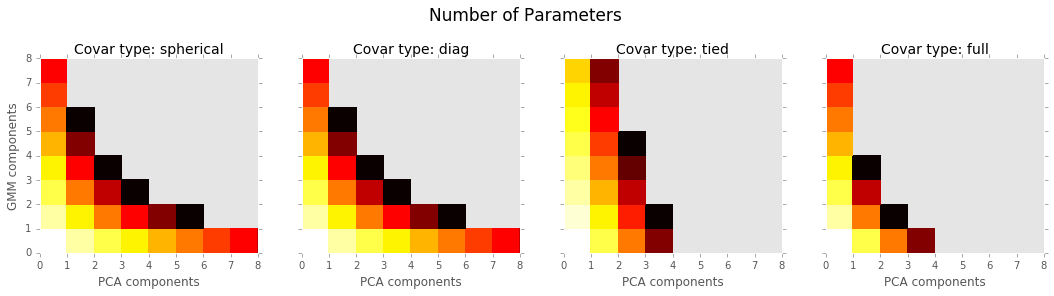

In [13]:
# Calculate the number of parameters for each PCA - GMM within [1,12]
pca_col, gmm_col = [], []
sph_col, diag_col, tied_col, full_col = [], [], [], []
for a in xrange(1,13):
    for b in xrange(1,13):
        pca_col.append(b)
        gmm_col.append(a)
        
        sph_col.append( num_params(b,a,'spherical') )
        diag_col.append( num_params(b,a,'diag') )
        tied_col.append( num_params(b,a,'tied') )
        full_col.append( num_params(b,a,'full') )

param_df = pd.DataFrame( {'pca': pca_col, 'gmm': gmm_col, 'spherical': sph_col, 
                          'diag': diag_col, 'tied': tied_col, 'full': full_col} )

# Plot heatmaps
fig, ax = plt.subplots(1, 4, figsize=(18,4), sharey=True)
for i,cov in enumerate(['spherical', 'diag', 'tied', 'full']):
    _img = param_df[cov].values.reshape(12,12)
    mask = _img>50
    masked_img = np.ma.masked_array(_img, mask)
    ax[i].pcolor(masked_img, cmap=plt.cm.hot_r)
    ax[i].plot()
    ax[i].invert_yaxis()
    ax[i].set_title('Covar type: {}'.format(cov), fontsize=14)
    ax[i].set_xlabel('PCA components')
    ax[i].set_xlim([0,8])
    ax[i].set_ylim([0,8])
    if i == 0:
        ax[i].set_ylabel('GMM components')

fig.suptitle('Number of Parameters', fontsize=17)
fig.subplots_adjust(top=.8)
plt.show()
    

The combinations with more than 50 parameters have been removed from the above heatmaps.  
  
Now let us list all possibilities and try them out:

In [14]:
_sp = param_df[param_df['spherical']<50][['pca', 'gmm', 'spherical']].rename(columns={'spherical': 'parameters'})
_sp['covariance'] = 'spherical'

_dg = param_df[param_df['diag']<50][['pca', 'gmm', 'diag']].rename(columns={'diag': 'parameters'})
_dg['covariance'] = 'diag'

_td = param_df[param_df['tied']<50][['pca', 'gmm', 'tied']].rename(columns={'tied': 'parameters'})
_td['covariance'] = 'tied'

_fu = param_df[param_df['full']<50][['pca', 'gmm', 'full']].rename(columns={'full': 'parameters'})
_fu['covariance'] = 'full'

# Total model combinations dataframe
models_df = pd.concat([_sp, _dg, _td, _fu], ignore_index=True)
print 'Total model combinations with less than 50 parameters:', models_df.shape[0]

Total model combinations with less than 50 parameters: 118


In [15]:
def P6(models, verbose=True):

### STUDENT START ###

    # Status updates for verbose printing
    TEMPL = {'total': 'TOTAL: [{ch:<59}] {done}/118 -> Best accuracy: {acc:.2%}',
             'spherical': '\tSpherical: [{ch:<35}] {done}/35 -> Best accuracy: {acc:.2%}',
             'diag': '\n\t Diagonal: [{ch:<35}] {done}/35 -> Best accuracy: {acc:.2%}',
             'tied': '\t     Tied: [{ch:<29}] {done}/29 -> Best accuracy: {acc:.2%}',
             'full': '\t     Full: [{ch:<19}] {done}/19 -> Best accuracy: {acc:.2%}' }

    def get_bar(cov):
        ''' Returns the formatted progress bar'''
        if cov == 'total':
            d = sum(mod_done.itervalues())
            l = d / 2
            a = max(best_acc.itervalues())
        else:
            d = mod_done[cov]
            l = d
            a = best_acc[cov]
        return TEMPL[cov].format(ch='#'*l, done=d, acc=a)

    # Initialize progress bars
    best_acc = {'spherical': 0, 'diag': 0, 'tied': 0, 'full': 0} 
    mod_done = {'spherical': 0, 'diag': 0, 'tied': 0, 'full': 0}

    # We will buffer the PCA-transformed data for each dimension
    pca_transformed = {}

    # We will store accuracy and time in the dataframe
    accuracy_col = []
    time_col = []

    # Iterate through all possible models
    for i,row in models.iterrows():
        # unpack parameters
        _pca, _gmm, _cov = row['pca'], row['gmm'], row['covariance']

        ## PCA decomposition
        if _pca not in pca_transformed:  # check if buffered
            _st = time.time()  # time PCA-transformation for buffering

            # Fit and transform data to 2d
            pca = PCA(n_components=_pca)
            _data = pca.fit_transform(train_data)

            # Split by positive - negative
            pos_data = _data[train_labels==1,:]
            neg_data = _data[train_labels==0,:]

            # Transform test dataset
            test_trans = pca.transform(test_data)

            t_pca = time.time() - _st  # stop timer

            # Buffer datasets and time
            pca_transformed[_pca] = { 'pos_data': pos_data, 'neg_data': neg_data,
                                      'test_data': test_trans, 'time': t_pca }
        else:
            pos_data = pca_transformed[_pca]['pos_data']
            neg_data = pca_transformed[_pca]['neg_data']
            test_trans = pca_transformed[_pca]['test_data']
            t_pca = pca_transformed[_pca]['time']


        ## GMM models (positive model & negative model)
        _st = time.time()  # time GMM model and prediction
        gm_pos = GMM(n_components=_gmm, covariance_type=_cov)
        gm_pos.fit(pos_data)

        gm_neg = GMM(n_components=_gmm, covariance_type=_cov)
        gm_neg.fit(neg_data)

        t_gmm = time.time() - _st  # stop timer

        # Calculate accuracy
        predicted = (gm_pos.score(test_trans) > gm_neg.score(test_trans)).astype(np.uint8)
        accuracy = 1. * (predicted == test_labels).sum() / len(test_labels)

        # Record accuracy - time
        accuracy_col.append(accuracy)
        time_col.append( t_pca + t_gmm )

        ## PROGRESS BAR
        best_acc[_cov] = max(best_acc[_cov], accuracy)  # update best_accuracy
        mod_done[_cov] += 1

        if verbose and (i % 10 == 0 or i==117):
            status = '\n'.join( map(get_bar, ['total', 'diag', 'spherical', 'tied', 'full']) )
            clear_output()
            print status

    acc = max(best_acc.itervalues())
    cov = max(best_acc, key=best_acc.get).upper()
    print '\nDONE!  --> The best model was a {} covariance type with {:.3%} accuracy'.format(cov, acc)

    # Add accuracies and time elapsed to the models dataframe
    models_df['accuracy'] = accuracy_col
    models_df['time'] = time_col
    
    return models_df

### STUDENT END ###

models_df = P6(models_df)

TOTAL: [###########################################################] 118/118 -> Best accuracy: 96.35%

	 Diagonal: [###################################] 35/35 -> Best accuracy: 95.02%
	Spherical: [###################################] 35/35 -> Best accuracy: 95.91%
	     Tied: [#############################] 29/29 -> Best accuracy: 96.35%
	     Full: [###################] 19/19 -> Best accuracy: 95.11%

DONE!  --> The best model was a TIED covariance type with 96.352% accuracy


In [16]:
models_df.sort_values('accuracy', ascending=False).head()

,pca,gmm,parameters,covariance,accuracy,time
80,3,3,36,tied,0.963523,0.089986
24,3,4,48,spherical,0.959075,0.122455
83,3,4,42,tied,0.951957,0.170570
109,2,4,48,full,0.951068,0.183541
86,3,5,48,tied,0.951068,0.159510


**As may be observed, the best model is 3d-PCA 3-GMM with `tied` covariance type (which amounts to 36 parameters) and has 96.35% accuracy.**